In [1]:
from pyfmi import load_fmu
import os 
import sys
import numpy as np
import pandas as pd
from pylab import *
from time import sleep
import seaborn as sn
from ddqn.environment import *
import calendar 
from datetime import timedelta, date
import logging
import math
import gym
from gym import spaces
from gym.utils import seeding
import gc
import pdb


import random
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import metrics


%matplotlib inline

plt.rcParams["figure.figsize"] = (15,8)

print(__doc__)

Using TensorFlow backend.


Automatically created module for IPython interactive environment


In [2]:
logger = logging.getLogger(__name__)
"""
EnergyPlus FMU model for co-simulation.
"""

class EP(gym.Env):
    
    reward_range = (-np.inf, np.inf)
    action_space = None
    observation_space = None
    
    def __init__(self, 
                 energy_plus_file,
                 state_size,
                 action_space,
                 solar_panel_area=50,
                 solar_panel_percent_active=0.9,
                 solar_panel_efficiency=0.9,
                 inverter_efficiency=0.9,
                 battery_discharge_efficiency=0.9,
                 battery_charge_efficiency=0.9,
                 battery_capacity=5000,
                 simulation_length=10):
        
        self.model = load_fmu(energy_plus_file, 
                              log_file_name='log_file.txt',
                              kind='auto')
        
        
        self.sim_duration = 86400
        self.numSteps = 144
        self.opts = self.model.simulate_options()
        self.opts['ncp'] = self.numSteps
        
        self.battery = Battery(capacity=battery_capacity,
                          charge_efficiency=battery_charge_efficiency,
                          discharge_efficiency=battery_discharge_efficiency)
        self.solar = SolarPanel(area=solar_panel_area,
                           f_active=solar_panel_percent_active,
                           eta_cell=solar_panel_efficiency,
                           eta_inv=inverter_efficiency)
        self._seed()
        self.action_space = action_space
        self.state = None
        self.state_size = state_size
        self.observation_space = None
        self.date =  datetime.date(2017, 1, 1)
        self.counter = 0
        self.store = pd.DataFrame({})
        self.time = self.model.time
        

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    
    def _step(self, action):
#         assert self.action_space.contains(action), "%r (%s) invalid"%(action, type(action))
        state = self.state
        
        start_time = self.counter * self.sim_duration
        final_time = (self.counter + 1) * self.sim_duration
        
        t = np.linspace(start_time,
                        final_time,
                        self.numSteps + 1, 
                        dtype=np.int32)



        battery_action = action_space[action] # replace with action 
        battery_flag = self.battery.step(battery_action)

#         avail_manager_action = action[:, 1]  # skipping the HVAC control for now
        avail_manager_action = np.random.randint(1, 2, 145)
        
        ut = np.transpose(np.vstack((t, np.repeat(avail_manager_action, 1))))
        input_object = ('Q', ut)

        res = self.model.simulate(start_time=start_time, 
                             final_time=final_time,
                             input=input_object,
                             options=self.opts)
        self.time = self.model.time


        df = pd.DataFrame({})
        for key in self.model.get_model_variables().keys():
            df[key] = res[key]
            
        df['managerAction'] = avail_manager_action 
        
        
        df[self.battery.id] = self.battery.get_history()['state'][self.counter * self.numSteps: 
                                                        (self.counter + 1) * self.numSteps + 1]
#         df['charge_discharge'] = self.battery.get_history()['current'][self.counter * self.numSteps: 
#                                                         (self.counter + 1) * self.numSteps + 1]
        df['charge_discharge'] = self.action_space[action]
        df['solar_generation'] = self.solar.step(res['directSolarRad'])
        df['substation_electiricty'] = res['totalDemand'] + df['charge_discharge'] - df['solar_generation']
        df.index = pd.DatetimeIndex(pd.date_range(str(self.date.month) + '/' + str(self.date.day) + '/' +
                                                  str(self.date.year), periods=145, freq='10min'))

        self.store = self.store.append(df)
        self.date = self.date + datetime.timedelta(days=1)
        
        self.state = df[['outdoorDbTemp', 'solar_generation', 
                         self.battery.id, 'totalDemand']]
        self.state['weekday'] = self.date.weekday()
        self.state['month'] = self.date.month
        
        #updating the counter
        self.counter += 1
        
        reward = - np.clip(df['substation_electiricty'], -1, 1)
        done = np.zeros(reward.shape[0]) > 1
        done[-1] = True
        
        return self.state.values, reward, done
    
    def _reset(self):
        self.state = np.random.uniform(low=-0.05, high=0.05,
                                      size=(145, self.state_size))
        return np.array(self.state)
    
    def _close(self):
        self.model.free_instance()
        gc.collect()


    
    
class Space(object):
    """Defines the observation and action spaces, so you can write generic
    code that applies to any Env. For example, you can choose a random
    action.
    """

    def sample(self):
        """
        Uniformly randomly sample a random element of this space
        """
        self.state = np.random.uniform(low=-0.05, high=0.05,
                                      size=(145, 4))
        return np.array(self.state)

    def contains(self, x):
        """
        Return boolean specifying if x is a valid
        member of this space
        """
        return True

    def to_jsonable(self, sample_n):
        """Convert a batch of samples from this space to a JSONable data type."""
        # By default, assume identity is JSONable
        return sample_n

    def from_jsonable(self, sample_n):
        """Convert a JSONable data type to a batch of samples from this space."""
        # By default, assume identity is JSONable
        return sample_n

    
    
class DDQNAgent(object):
    """
    Deep Q-Learning agent implementation.
    """
    
    
    def __init__(self, state_size, action_size, 
                 memory_lenght, discount=0.99, epsilon=1):
        
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=memory_lenght)
        self.gamma = discount
        self.epsilon = epsilon
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        self.learning_rate = 0.001
        self.network = self._build_network()
        self.target_network = self._build_network()
        self.update_target_network()
        self.advantage = []
        self.value = []
        self.target = []
        
    
    def _build_network(self):
        """
        build neural network for Deep Q-learning model.
        """
        
        network = Sequential()
        network.add(Dense(256, input_dim=self.state_size,
                         activation='tanh'))
        network.add(Dense(512, activation='tanh'))
        network.add(Dense(256, activation='tanh'))
        network.add(Dense(64, activation='tanh'))
        network.add(Dense(32, activation='tanh'))
        network.add(Dense(16, activation='tanh'))
        network.add(Dense(self.action_size, activation='linear'))
        network.compile(loss='mse',
                        metrics=[metrics.mse],
                       optimizer=Adam(lr=self.learning_rate))
        return network

    def update_target_network(self):
        # copy weights from model to target_model
        self.target_network.set_weights(self.network.get_weights())
        
    def remember(self, state, action, reward, next_state, done):
        for mem in zip(state, action, reward, next_state, done):
            self.memory.append(mem)

    
    def act(self, states):
        actions = []
        for state in states:
            if np.random.rand() <= self.epsilon:
                actions.append(random.randrange(self.action_size))
            else:
                action_value = self.network.predict(state.reshape((1, self.state_size)))
                actions.append(np.argmax(action_value))
        return actions
    
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = self.network.predict(state.reshape((1, self.state_size)))
            if done:
                target[0][action] = reward
            else:
                a = self.network.predict(next_state.reshape((1, self.state_size)))[0]
                t = self.target_network.predict(next_state.reshape((1, self.state_size)))[0]
                self.advantage.append(a)
                self.value.append(t)
                target[0][action] = reward + self.gamma * t[np.argmax(a)]
                self.target.append(target[0])
            self.network.fit(state.reshape((1,self.state_size)), target, epochs=1, verbose=1)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        
    def load(self, name):
        self.network.load_weights(name)

    def save(self, name):
        self.network.save_weights(name)  
        
def pplot(ax,y, colors=['b']):
    x = range(len(y))
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(x)
            line.set_ydata(y)
    else:
        for color in colors:
            ax.plot(x, y, color)
    fig.canvas.draw()
    
    
def check_path(path):
    if path != os.getcwd():
        os.chdir(path)
    

In [5]:
if __name__ == "__main__":
#     %matplotlib notebook
    path = '/home/mfc/Projects/research/small_office/'
    check_path(path)
    state_size = 6
    action_size = 5
    action_space = np.linspace(-10000, 10000, action_size)

    try:
        env.model.free_instance()
        env.model.initialize()
    except: pass
    env = EP('./EPlus/small_office.fmu', state_size=state_size,
             battery_capacity=20000, action_space=action_space, solar_panel_area=30)

    agent = DDQNAgent(state_size, action_size, memory_lenght=10000, 
                      discount=0.99, epsilon=1)
    done = False
    batch_size = 20
    load_weights = 1
    episodes = 70
    reward_list = []
    r_list = np.array([])
    total_reward = 0
    
    if 'save' not in os.listdir('.'):
        os.mkdir('./save/')
    
    if load_weights:
        agent.load('./save/ddqn.h5')
        
        
    for e in range(episodes):
        check_path(path)
        states = env.reset()
        states = np.reshape(states, [states.shape[0], state_size])
        for time in range(2):
            actions = agent.act(states)
            next_state, reward, done = env.step(actions)
            next_state = np.reshape(next_state, [next_state.shape[0], state_size])
            agent.remember(states, actions, reward, next_state, done)
            states = next_state
            total_reward += reward.sum()
            reward_list.append(total_reward)
            r_list = np.append(r_list, reward)
#             if done:
#                 break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
        if e % 4 == 0:
            agent.update_target_network()
            agent.save("./save/ddqn.h5")
            print("episode: {}/{}, score: {}, e: {}".format(e, episodes,time, agent.epsilon))
            
#         fig,ax = plt.subplots(1,1, figsize=(10, 8))
#         ax.set_xlabel('episode')
#         ax.set_ylabel('reward')
#         ax.set_xlim(0,e + 5)
#         ax.set_ylim(-1000, 1000)
#         pplot(ax, reward_list, ['b'])
            


Simulation interval    : 0 - 86400.0 seconds.
Elapsed simulation time: 0.0481109619141 seconds.


/home/mfc/.virtualenvs/research/lib/python2.7/site-packages/ipykernel_launcher.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mfc/.virtualenvs/research/lib/python2.7/site-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Simulation interval    : 86400 - 172800.0 seconds.
Elapsed simulation time: 0.0559771060944 seconds.
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.3271 - mean_squared_error: 1.3271
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3822 - mean_squared_error: 0.3822
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.6556 - mean_squared_error: 1.6556
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.8009 - mean_squared_error: 0.8009
Epoch 1/1
1/1 [==============================] - 0s - loss: 2.0076 - mean_squared_error: 2.0076
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.4026 - mean_squared_error: 1.4026
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.7008 - mean_squared_error: 1.7008
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2350 - mean_squared_error: 0.2350
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3859 - mean_squared_error: 0.3859
Epoch 1/1
1/1 [====================

1/1 [==============================] - 0s - loss: 0.0162 - mean_squared_error: 0.0162
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2346 - mean_squared_error: 0.2346
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0155 - mean_squared_error: 0.0155
Simulation interval    : 691200 - 777600.0 seconds.
Elapsed simulation time: 0.0520658493042 seconds.
Simulation interval    : 777600 - 864000.0 seconds.
Elapsed simulation time: 0.0628061294556 seconds.
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0150 - mean_squared_error: 0.0150
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0254 - mean_squared_error: 0.0254
Epoch 1/1
1/1 [=======================

1/1 [==============================] - 0s - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2701 - mean_squared_error: 0.2701
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1458 - mean_squared_error: 0.1458
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0084 - mean_squared_error: 0.0084
Simulation interval    : 1382400 - 1468800.0 seconds.
Elapsed simulation time: 0.057336807251 seconds.
Simulation interval    : 1468800 - 1555200.0 seconds.
Elapsed simulation time: 0.0497360229492 seconds.
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 1/1
1/1 [====================

1/1 [==============================] - 0s - loss: 0.2019 - mean_squared_error: 0.2019
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2221 - mean_squared_error: 0.2221
Epoch 1/1
1/1 [==============================] - 0s - loss: 6.9663 - mean_squared_error: 6.9663
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2341 - mean_squared_error: 0.2341
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0098 - mean_squared_error: 0.0098
Epoch 1/1
1/1 [==============================] - 0

1/1 [==============================] - 0s - loss: 0.8093 - mean_squared_error: 0.8093
Epoch 1/1
1/1 [==============================] - 0s - loss: 3.3714 - mean_squared_error: 3.3714
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.5459 - mean_squared_error: 0.5459
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.6151 - mean_squared_error: 0.6151
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.6480 - mean_squared_error: 0.6480
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.5748 - mean_squared_error: 0.5748
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 1/1
1/1 [==============================] - 0s - loss: 3.3122 - mean_squared_error: 3.3122
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4780 - mean_squared_error: 0.4780
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2125 - mean_squared_error: 0.2125
Epoch 1/1
1/1 [==============================] - 0

1/1 [==============================] - 0s - loss: 0.0820 - mean_squared_error: 0.0820
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0795 - mean_squared_error: 0.0795
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1338 - mean_squared_error: 0.1338
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2332 - mean_squared_error: 0.2332
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2247 - mean_squared_error: 0.2247
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0696 - mean_squared_error: 0.0696
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2057 - mean_squared_error: 0.2057
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0119 - mean_squared_error: 0.0119
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0205 - mean_squared_error: 0.0205
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0146 - mean_squared_error: 0.0146
Epoch 1/1
1/1 [==============================] - 0

1/1 [==============================] - 0s - loss: 0.2488 - mean_squared_error: 0.2488
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0354 - mean_squared_error: 0.0354
Simulation interval    : 3974400 - 4060800.0 seconds.
Elapsed simulation time: 0.057648897171 seconds.
Simulation interval    : 4060800 - 4147200.0 seconds.
Elapsed simulation time: 0.0792009830475 seconds.
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.5161 - mean_squared_error: 0.5161
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0250 - mean_squared_error: 0.0250
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0220 - mean_squared_error: 0.0220
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0263 - mean_squared_error: 0.0263
Epoch 1/1
1/1 [====================

1/1 [==============================] - 0s - loss: 0.3004 - mean_squared_error: 0.3004
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2145 - mean_squared_error: 0.2145
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0201 - mean_squared_error: 0.0201
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1249 - mean_squared_error: 0.1249
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0271 - mean_squared_error: 0.0271
Simulation interval    : 4665600 - 4752000.0 seconds.
Elapsed simulation time: 0.0570058822632 seconds.
Simulation interval    : 4752000 - 4838400.0 seconds.
Elapsed simulation time: 0.0473849773407 seconds.
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0171 - mean_squared_error: 0.0171
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2370 - mean_squared_error: 0.2370
Epoch 1/1
1/1 [===================

1/1 [==============================] - 0s - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 1/1
1/1 [==============================] - 0s - loss: 4.2186 - mean_squared_error: 4.2186
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1597 - mean_squared_error: 0.1597
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1553 - mean_squared_error: 0.1553
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2526 - mean_squared_error: 0.2526
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1520 - mean_squared_error: 0.1520
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1065 - mean_squared_error: 0.1065
Epoch 1/1
1/1 [==============================] - 0

1/1 [==============================] - 0s - loss: 0.0814 - mean_squared_error: 0.0814
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4342 - mean_squared_error: 0.4342
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0758 - mean_squared_error: 0.0758
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0729 - mean_squared_error: 0.0729
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0705 - mean_squared_error: 0.0705
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0621 - mean_squared_error: 0.0621
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1719 - mean_squared_error: 0.1719
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 1/1
1/1 [==============================] - 0

1/1 [==============================] - 0s - loss: 0.0590 - mean_squared_error: 0.0590
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0677 - mean_squared_error: 0.0677
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0459 - mean_squared_error: 0.0459
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0667 - mean_squared_error: 0.0667
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0952 - mean_squared_error: 0.0952
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4186 - mean_squared_error: 0.4186
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3627 - mean_squared_error: 0.3627
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0210 - mean_squared_error: 0.0210
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0837 - mean_squared_error: 0.0837
Epoch 1/1
1/1 [==============================] - 0

1/1 [==============================] - 0s - loss: 0.1813 - mean_squared_error: 0.1813
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2651 - mean_squared_error: 0.2651
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2674 - mean_squared_error: 0.2674
Simulation interval    : 7257600 - 7344000.0 seconds.
Elapsed simulation time: 0.0544288158417 seconds.
Simulation interval    : 7344000 - 7430400.0 seconds.
Elapsed simulation time: 0.0586760044098 seconds.
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1423 - mean_squared_error: 0.1423
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1412 - mean_squared_error: 0.1412
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0138 - mean_squared_error: 0.0138
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1364 - mean_squared_error: 0.1364
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0709 - mean_squared_error: 0.0709
Epoch 1/1
1/1 [===================

1/1 [==============================] - 0s - loss: 0.1649 - mean_squared_error: 0.1649
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1622 - mean_squared_error: 0.1622
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.8611 - mean_squared_error: 0.8611
Epoch 1/1
1/1 [==============================] - 0s - loss: 4.4684e-04 - mean_squared_error: 4.4684e-04
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1487 - mean_squared_error: 0.1487
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3400 - mean_squared_error: 0.3400
Simulation interval    : 7948800 - 8035200.0 seconds.
Elapsed simulation time: 0.052178144455 seconds.
Simulation interval    : 8035200 - 8121600.0 seconds.
Elapsed simulation time: 0.0525641441345 seconds.
Epoch 1/1
1/1 [============

1/1 [==============================] - 0s - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0162 - mean_squared_error: 0.0162
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0443 - mean_squared_error: 0.0443
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4685 - mean_squared_error: 0.4685
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4652 - mean_squared_error: 0.4652
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1794 - mean_squared_error: 0.1794
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4497 - mean_squared_error: 0.4497
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0204 - mean_squared_error: 0.0204
Epoch 1/1
1/1 [==============================] - 0

1/1 [==============================] - 0s - loss: 0.0197 - mean_squared_error: 0.0197
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4541 - mean_squared_error: 0.4541
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1602 - mean_squared_error: 0.1602
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2479 - mean_squared_error: 0.2479
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0099 - mean_squared_error: 0.0099
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0190 - mean_squared_error: 0.0190
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0103 - mean_squared_error: 0.0103
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4283 - mean_squared_error: 0.4283
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0145 - mean_squared_error: 0.0145
Epoch 1/1
1/1 [==============================] - 0

Simulation interval    : 9849600 - 9936000.0 seconds.
Elapsed simulation time: 0.0608098506927 seconds.
Simulation interval    : 9936000 - 10022400.0 seconds.
Elapsed simulation time: 0.0583829879761 seconds.
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0127 - mean_squared_error: 0.0127
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.5333 - mean_squared_error: 0.5333
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1679 - mean_squared_error: 0.1679
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1655 - mean_squared_error: 0.1655
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0117 - mean_squared_error: 0.0117
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0151 - mean_squared_error: 0.0151
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.5092 - mean_squared_error: 0.5092
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1545 - mean_squared_error: 0.1545
Epoch 1/1
1/1 [========

1/1 [==============================] - 0s - loss: 4.0788e-05 - mean_squared_error: 4.0788e-05
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0614 - mean_squared_error: 0.0614
Epoch 1/1
1/1 [==============================] - 0s - loss: 5.8778e-05 - mean_squared_error: 5.8778e-05
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0014 - mean_squared_error: 0.0014
episode: 60/70, score: 1, e: 0.541685075967
Simulation interval    : 10540800 - 10627200.0 seconds.
Elapsed simulation time: 0.0502729415894 seconds.
Simulation interval    : 10627200 - 10713600.0 seconds.
Elapsed simulation time: 0.0529580116272 seconds.
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1695 - mean_squared_error: 0.1695
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.0966 - mean_squared_error: 1.0966
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0582 - mean_squared_error: 0.0582
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1683

1/1 [==============================] - 0s - loss: 0.0189 - mean_squared_error: 0.0189
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0554 - mean_squared_error: 0.0554
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0236 - mean_squared_error: 0.0236
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0542 - mean_squared_error: 0.0542
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4404 - mean_squared_error: 0.4404
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4159 - mean_squared_error: 0.4159
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0162 - mean_squared_error: 0.0162
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0537 - mean_squared_error: 0.0537
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0153 - mean_squared_error: 0.0153
episode: 64/70, score: 1, e: 0.52034052265
Simulation interval    : 11232000 - 11318400.0 seconds.
Elapsed simulation time: 0.0520219802856 second

1/1 [==============================] - 0s - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0759 - mean_squared_error: 0.0759
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0272 - mean_squared_error: 0.0272
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0264 - mean_squared_error: 0.0264
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0255 - mean_squared_error: 0.0255
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0967 - mean_squared_error: 0.0967
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0963 - mean_squared_error: 0.0963
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.3469 - mean_squared_error: 1.3469
Epoch 1/1
1/1 [==============================] - 0

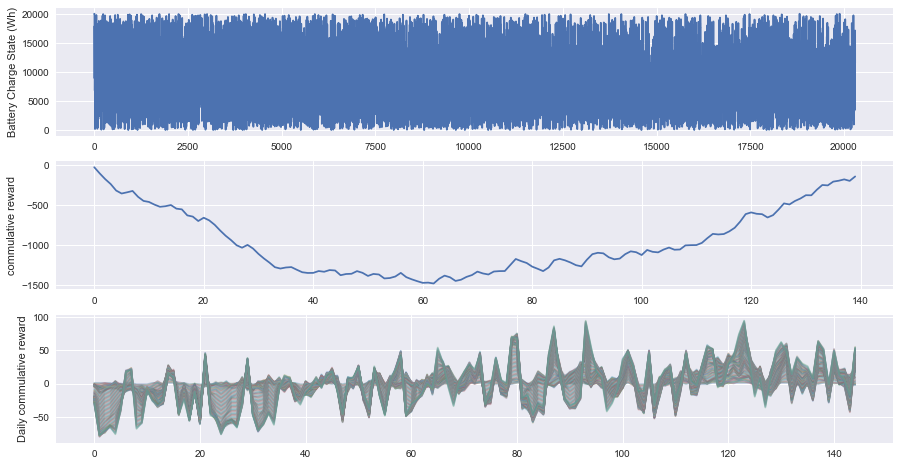

In [7]:
plt.subplot(311)
plt.plot(env.battery.state)
plt.ylabel('Battery Charge State (Wh)')

plt.subplot(312)
plt.plot(reward_list)
plt.ylabel('commulative reward')


plt.subplot(313)
a=plt.plot(np.cumsum(r_list.reshape(145, r_list.shape[0]/ 145), axis=1), alpha =0.3)
plt.ylabel('Daily commulative reward')

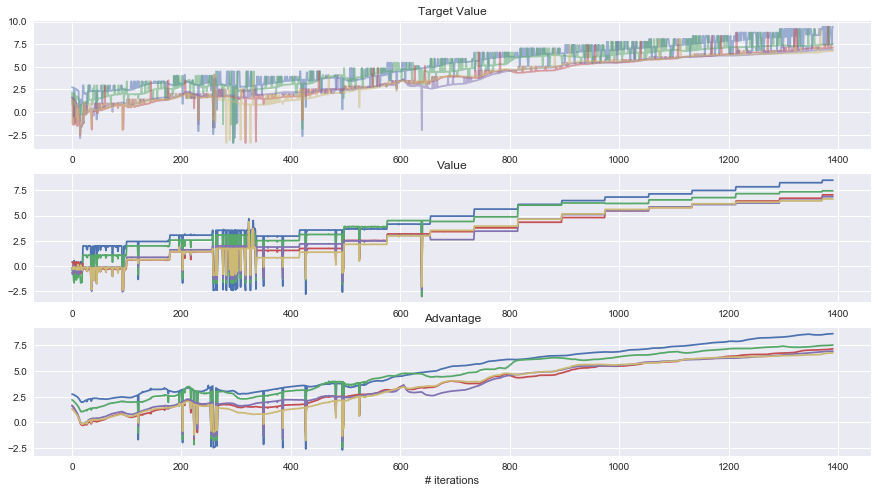

In [8]:
plt.subplot(311)
plt.plot(agent.target, alpha=.5)
plt.title('Target Value')
# plt.ylim((35,45))

plt.subplot(312)
plt.plot(agent.value)
plt.title('Value')
# plt.ylim((35,45))


plt.subplot(313)
plt.plot(agent.advantage)
plt.title('Advantage')
plt.xlabel('# iterations')

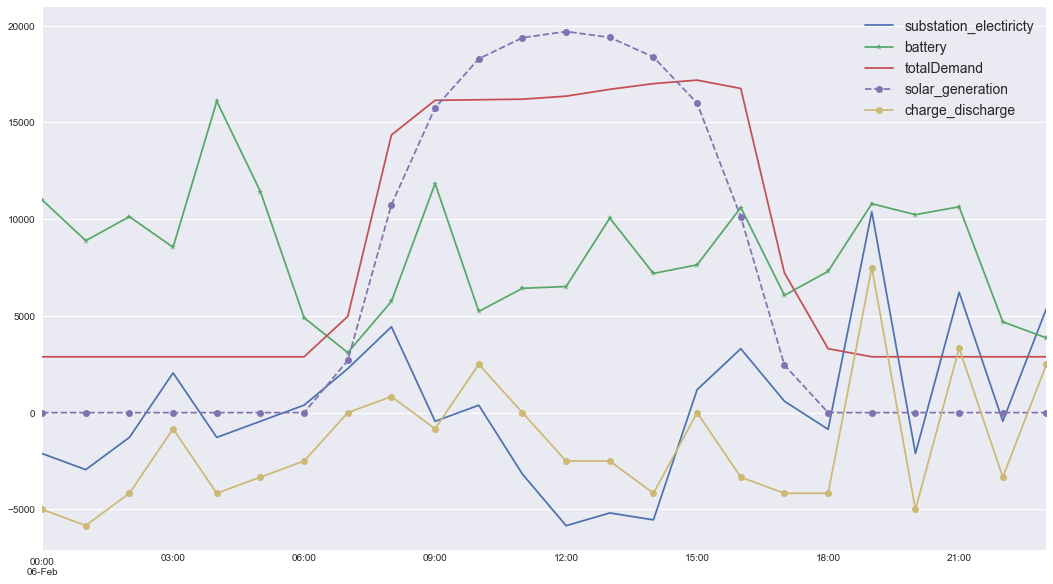

In [21]:
date = '2017-02-06'
env.store.substation_electiricty.resample('1H').mean()[date].plot(figsize=(18, 10))
env.store.battery.resample('1H').mean()[date].plot(style='-*')
env.store.totalDemand.resample('1H').mean()[date].plot(style='-')
env.store.solar_generation.resample('1H').mean()[date].plot(style='--o')
env.store.charge_discharge.resample('1H').mean()[date].plot(style='-o')
plt.legend(loc=1, fontsize=14)

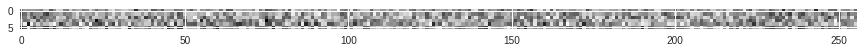

In [9]:
plt.imshow(agent.network.get_weights()[0])


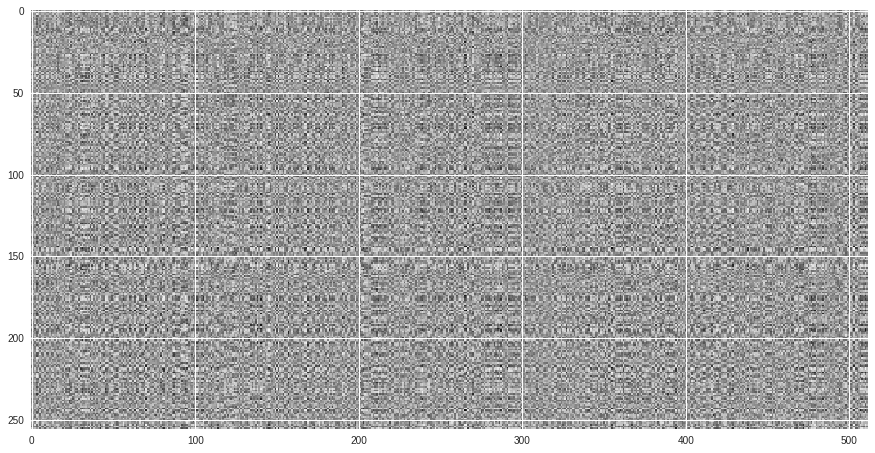

In [10]:
plt.imshow(agent.network.get_weights()[2])

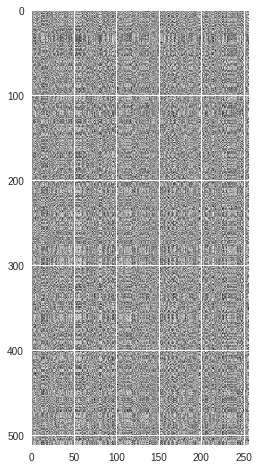

In [11]:
plt.imshow(agent.network.get_weights()[4])

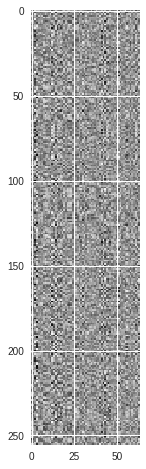

In [12]:
plt.imshow(agent.network.get_weights()[6])

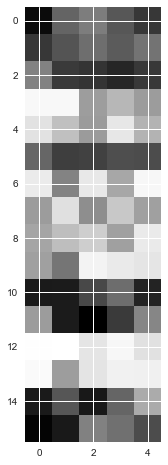

In [15]:
plt.imshow(agent.network.get_weights()[12])